1) Imports & Reproducibility

In [14]:
# --- imports & seeds ---
from io import StringIO
import sys
import os, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import shap

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, f1_score)

from google.colab import drive

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2) Data Loading & Preprocessing

In [15]:
# --- data loading & preprocessing ---
def preprocess_data(df, seed=SEED):
    dfp = df.copy()

    # encode categoricals
    categorical_cols = ['education', 'self_employed']
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        dfp[col] = le.fit_transform(dfp[col].astype(str))
        label_encoders[col] = le

    # target mapping
    status_map = {'Approved': 1, 'Rejected': 0}
    dfp['loan_status'] = dfp['loan_status'].map(status_map).astype(int)
    label_encoders['loan_status'] = status_map

    # base features
    base_cols = [
        'no_of_dependents','education','self_employed','income_annum',
        'loan_amount','loan_term','cibil_score','residential_assets_value',
        'commercial_assets_value','luxury_assets_value','bank_asset_value'
    ]

    X = dfp[base_cols].copy()
    y = dfp['loan_status'].copy()

    # derived feature
    asset_cols = ['residential_assets_value','commercial_assets_value',
                  'luxury_assets_value','bank_asset_value']
    X['has_debt'] = (X[asset_cols].lt(0).any(axis=1)).astype(int)

    feature_cols = base_cols + ['has_debt']

    # impute & split (70/15/15 stratified)
    X = X.fillna(X.median(numeric_only=True))
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=seed
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=seed
    )

    # scale using train only
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    return (X_train, y_train, X_val, y_val, X_test, y_test,
            scaler, label_encoders, feature_cols)

#Loading Data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BT4222 Datasets/loan_approval_dataset.csv")


3) TensorDatasets & DataLoaders

In [16]:
# --- dataloaders ---
def to_tensor_ds(X, y):
    y_arr = y.values.reshape(-1, 1) if hasattr(y, "values") else np.array(y).reshape(-1, 1)
    return TensorDataset(torch.tensor(X, dtype=torch.float32),
                         torch.tensor(y_arr, dtype=torch.float32))

def make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    train_ds = to_tensor_ds(X_train, y_train)
    val_ds   = to_tensor_ds(X_val,   y_val)
    test_ds  = to_tensor_ds(X_test,  y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


4) Model Architecture

In [17]:
# --- model ---
class LoanApprovalModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 512); self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256);        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128);        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128,  64);        self.bn4 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear( 64,  32);        self.bn5 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)  # logits

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x))); x = self.dropout1(x)
        x = F.relu(self.bn2(self.layer2(x))); x = self.dropout2(x)
        x = F.relu(self.bn3(self.layer3(x))); x = self.dropout3(x)
        x = F.relu(self.bn4(self.layer4(x)))
        x = F.relu(self.bn5(self.layer5(x)))
        return self.output(x)  # raw logits


5) Loss function, Optimizer, Scheduler

In [18]:
# --- training config helpers ---
def make_training_objects(model, y_train):
    pos = float(y_train.sum())
    neg = float(len(y_train) - y_train.sum())
    pos_weight_value = (neg / max(pos, 1.0)) if pos > 0 else 1.0

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=DEVICE))
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    return criterion, optimizer, scheduler


6) Model Training (with Early Stopping)

In [19]:
# --- training loop ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                epochs=10, early_stop_patience=20, ckpt_path='best_model.pth'):
    train_losses, val_losses, train_accs, val_accs, lrs = [], [], [], [], []
    best_val = float('inf'); patience = 0

    for epoch in range(epochs):
        # train
        model.train()
        tloss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            tloss += loss.item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = tloss / len(train_loader)
        train_acc = 100.0 * correct / total

        # val
        model.eval()
        vloss, vcorrect, vtotal = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                vloss += criterion(logits, y).item()
                preds = (torch.sigmoid(logits) > 0.5).float()
                vcorrect += (preds == y).sum().item()
                vtotal += y.size(0)

        val_loss = vloss / len(val_loader)
        val_acc = 100.0 * vcorrect / vtotal

        scheduler.step(val_loss)
        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc);    val_accs.append(val_acc)
        lrs.append(optimizer.param_groups[0]['lr'])

        # early stopping
        if val_loss < best_val:
            best_val = val_loss; patience = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            patience += 1
            if patience >= early_stop_patience:
                break

    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    return train_losses, val_losses, train_accs, val_accs, lrs


7) Threshold Tuning (by F1 on Validation)

In [20]:
# --- threshold tuning ---
def tune_threshold(model, loader):
    model.eval()
    probs_all, y_all = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            probs = torch.sigmoid(model(x)).cpu().numpy().ravel()
            probs_all.append(probs); y_all.append(y.cpu().numpy().ravel())
    probs = np.concatenate(probs_all); y_true = np.concatenate(y_all)

    ths = np.linspace(0.05, 0.95, 19)
    f1s = []
    for t in ths:
        f1s.append(f1_score(y_true, (probs >= t).astype(int)))
    best_idx = int(np.argmax(f1s))
    return float(ths[best_idx]), float(f1s[best_idx])


8) Model Evaluation

In [21]:
# --- evaluation ---
def evaluate(model, loader, criterion, threshold=0.5, label_names=('Rejected','Approved')):
    model.eval()
    tloss, correct, total = 0.0, 0, 0
    probs_all, y_all = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            tloss += criterion(logits, y).item()
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            probs_all.append(probs); y_all.append(y.cpu().numpy().ravel())
            preds = (probs >= threshold).astype(np.float32)
            correct += (preds == y.cpu().numpy().ravel()).sum()
            total += len(preds)

    loss = tloss / len(loader)
    probs = np.concatenate(probs_all); y_true = np.concatenate(y_all)
    acc = 100.0 * correct / total
    auc = roc_auc_score(y_true, probs)

    preds_bin = (probs >= threshold).astype(int)
    print(f"Loss: {loss:.4f} | Acc: {acc:.2f}% | AUC: {auc:.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, preds_bin, target_names=list(label_names)))

    cm = confusion_matrix(y_true, preds_bin)
    plt.figure(figsize=(5.5,4.5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=list(label_names), yticklabels=list(label_names))
    plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(y_true, probs)
    plt.figure(figsize=(5.5,4.5)); plt.plot(fpr, tpr, label=f'AUC={auc:.3f}'); plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, probs)
    plt.figure(figsize=(5.5,4.5)); plt.plot(rec, prec)
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve'); plt.tight_layout(); plt.show()

    return acc, auc, probs, y_true


9) Permutation Feature Importance

In [22]:
# --- permutation feature importance ---
def permutation_importance(model, feature_cols, loader, top_k=10):
    model.eval()
    with torch.no_grad():
        batch_x, _ = next(iter(loader))
        batch_x = batch_x.to(DEVICE)
        base = torch.sigmoid(model(batch_x)).mean().item()

    n = batch_x.size(0)
    imps = {}
    for i, fname in enumerate(feature_cols):
        with torch.no_grad():
            perm = torch.randperm(n, device=DEVICE)
            pert = batch_x.clone()
            pert[:, i] = pert[perm, i]
            imp = base - torch.sigmoid(model(pert)).mean().item()
            imps[fname] = imp

    ranked = sorted(imps.items(), key=lambda x: abs(x[1]), reverse=True)
    feats, vals = zip(*ranked[:top_k])
    plt.figure(figsize=(7,4.5)); plt.barh(feats, vals); plt.xlabel('Δ mean prob'); plt.title('Top Feature Importance')
    plt.tight_layout(); plt.show()
    return ranked


10) Execution

Mounted at /content/drive
Best threshold (val F1): 0.450 | F1=0.9783
Loss: 0.0840 | Acc: 95.01% | AUC: 0.9920

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.91      0.96      0.94       242
    Approved       0.98      0.94      0.96       399

    accuracy                           0.95       641
   macro avg       0.94      0.95      0.95       641
weighted avg       0.95      0.95      0.95       641



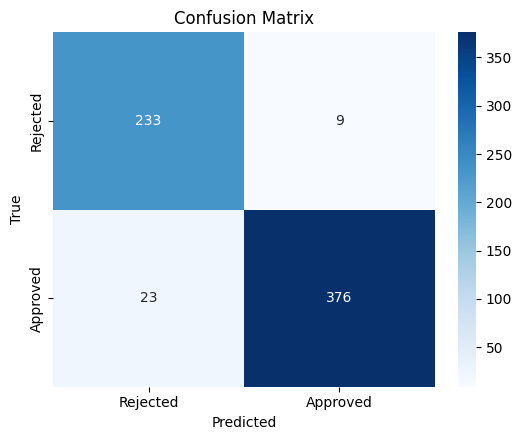

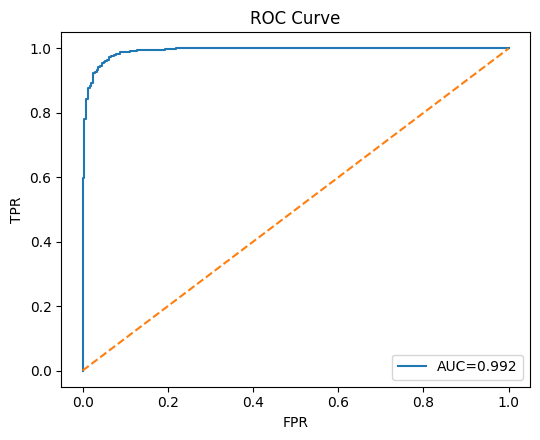

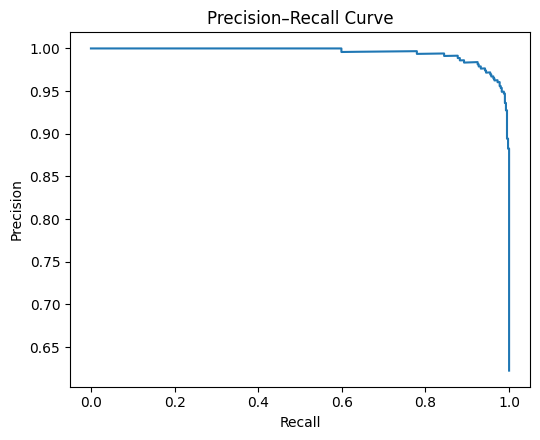

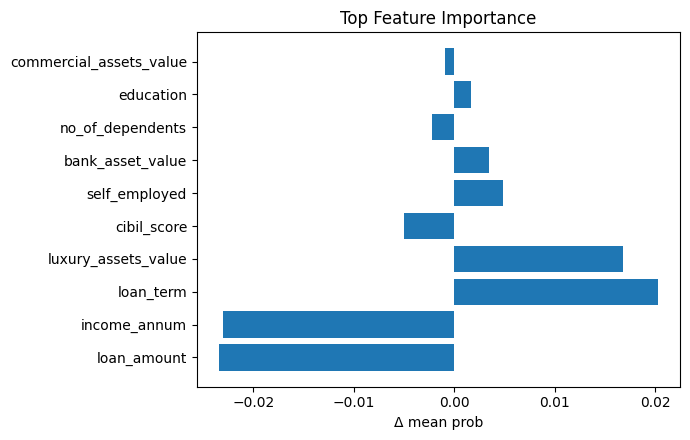

In [23]:
# --- main run  ---
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BT4222 Datasets/loan_approval_dataset.csv")

# 1) preprocess
X_train, y_train, X_val, y_val, X_test, y_test, scaler, encoders, feature_cols = preprocess_data(df)

# 2) loaders
train_loader, val_loader, test_loader = make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64)

# 3) model & training objects
model = LoanApprovalModel(input_size=len(feature_cols)).to(DEVICE)
criterion, optimizer, scheduler = make_training_objects(model, y_train)

# 4) train
train_losses, val_losses, train_accs, val_accs, lrs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    epochs=10, early_stop_patience=20, ckpt_path='best_loan_model.pth'
)

# 5) tune threshold on validation
best_thr, best_f1 = tune_threshold(model, val_loader)
print(f"Best threshold (val F1): {best_thr:.3f} | F1={best_f1:.4f}")

# 6) evaluate on test
acc, auc, probs, y_true = evaluate(model, test_loader, criterion, threshold=best_thr)

# 7) feature importance
ranked_imps = permutation_importance(model, feature_cols, test_loader, top_k=10)

11. Equalised Odds


In [24]:
def equalised_odds_by_group(y_true, y_pred, group_values, group_name="Group"):
    """
    Compute Equalised Odds metrics (TPR/FPR per group) and their differences.

    Parameters:
        y_true (array-like): True binary labels (0/1)
        y_pred (array-like): Predicted binary labels (0/1)
        group_values (array-like): Sensitive attribute values (e.g. education levels)
        group_name (str): Name of the group for reporting

    Returns:
        results_df (pd.DataFrame): TPR/FPR for each group
        eo_diff (dict): Differences in TPR/FPR across groups
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'group': group_values
    })

    results = []
    for g, sub in df.groupby('group'):
        tn, fp, fn, tp = confusion_matrix(sub['y_true'], sub['y_pred']).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # recall for positive class
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # false positive rate
        results.append({'Group': g, 'TPR': tpr, 'FPR': fpr})

    results_df = pd.DataFrame(results)
    tpr_diff = results_df['TPR'].max() - results_df['TPR'].min()
    fpr_diff = results_df['FPR'].max() - results_df['FPR'].min()

    print(f"\n=== Equalised Odds for {group_name} ===")
    print(results_df.to_string(index=False))
    print(f"\nTPR Difference: {tpr_diff:.4f}")
    print(f"FPR Difference: {fpr_diff:.4f}")

    eo_diff = {'TPR_diff': tpr_diff, 'FPR_diff': fpr_diff}
    return results_df, eo_diff

12) EOD Results

In [25]:
# true labels and predictions from your test set
y_pred = (probs >= best_thr).astype(int)

# subgroup columns (assuming from your original dataframe or label encoder)
education_groups = df.loc[y_test.index, 'education']
employment_groups = df.loc[y_test.index, 'self_employed']
dependents_groups = df.loc[y_test.index, 'no_of_dependents']

# compute equalised odds per attribute
eq_edu, edu_diff = equalised_odds_by_group(y_true, y_pred, education_groups, group_name="Education")
eq_emp, emp_diff = equalised_odds_by_group(y_true, y_pred, employment_groups, group_name="Employment Type")
eq_dep, dep_diff = equalised_odds_by_group(y_true, y_pred, dependents_groups, group_name="Number of Dependents")



=== Equalised Odds for Education ===
       Group      TPR     FPR
    Graduate 0.942408 0.02500
Not Graduate 0.942308 0.04918

TPR Difference: 0.0001
FPR Difference: 0.0242

=== Equalised Odds for Employment Type ===
Group      TPR      FPR
   No 0.965686 0.047244
  Yes 0.917949 0.026087

TPR Difference: 0.0477
FPR Difference: 0.0212

=== Equalised Odds for Number of Dependents ===
 Group      TPR      FPR
     0 0.920635 0.052632
     1 0.942857 0.000000
     2 0.948276 0.071429
     3 0.969231 0.088889
     4 0.946667 0.000000
     5 0.926471 0.000000

TPR Difference: 0.0486
FPR Difference: 0.0889


13) SHAP Evaluation

In [26]:
# --- Customer-Friendly SHAP Explanation ---
# --- Fixed Customer-Friendly SHAP Explanation ---
def generate_customer_explanation(model, application_data, feature_cols, scaler, label_encoders, threshold=0.5):
    """
    Generate a customer-readable explanation for loan decisions
    """
    print("=" * 70)
    print("🏦 LOAN APPLICATION DECISION")
    print("=" * 70)

    # Prepare the application data
    app_df = pd.DataFrame([application_data])

    # Handle categorical encoding
    if 'education' in application_data and 'education' in label_encoders:
        app_df['education'] = label_encoders['education'].transform([app_df['education'].iloc[0]])[0]
    if 'self_employed' in application_data and 'self_employed' in label_encoders:
        app_df['self_employed'] = label_encoders['self_employed'].transform([app_df['self_employed'].iloc[0]])[0]

    # Ensure all feature columns are present
    for col in feature_cols:
        if col not in app_df.columns:
            app_df[col] = 0

    X_customer = scaler.transform(app_df[feature_cols])

    # Get prediction
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_customer, dtype=torch.float32).to(DEVICE)
        probability = torch.sigmoid(model(X_tensor)).cpu().numpy()[0][0]
        prediction = probability >= threshold

    # Display decision clearly
    if prediction:
        print(f"✅ APPROVED")
        print(f"📊 Approval Score: {probability:.1%}")
        print(f"🎯 Minimum Required: {threshold:.1%}")
        print("\n" + "🎉 Congratulations! Your loan application has been approved.")

        print("\n" + "=" * 70)
        print("📋 APPLICATION SUMMARY")
        print("=" * 70)

        # Display key application details
        key_details = {
            'Annual Income': f"₹{application_data['income_annum']:,}",
            'Loan Amount': f"₹{application_data['loan_amount']:,}",
            'Loan Term': f"{application_data['loan_term']} years",
            'Credit Score': f"{application_data['cibil_score']}",
            'Dependents': f"{application_data['no_of_dependents']} people",
            'Employment': f"{'Self-Employed' if application_data['self_employed'] == 'Yes' else 'Salaried'}",
            'Education': f"{application_data['education']}",
            'Existing Debt': f"{'Yes' if application_data.get('has_debt', 0) == 1 else 'No'}"
        }

        for key, value in key_details.items():
            print(f"  • {key}: {value}")

        return {
            'prediction': prediction,
            'probability': probability,
            'top_rejection_factors': [],
            'recommendations': []
        }

    # REJECTED APPLICATION - FULL EXPLANATION
    print(f"❌ NOT APPROVED")
    print(f"📊 Your Score: {probability:.1%}")
    print(f"🎯 Required Score: {threshold:.1%}")
    print(f"📉 Short by: {(threshold - probability):.1%} points")
    print("\n" + "We appreciate your application, but based on our assessment, we are unable to approve it at this time.")

    print("\n" + "=" * 70)
    print("📋 APPLICATION SUMMARY")
    print("=" * 70)

    # Display key application details
    key_details = {
        'Annual Income': f"₹{application_data['income_annum']:,}",
        'Loan Amount': f"₹{application_data['loan_amount']:,}",
        'Loan Term': f"{application_data['loan_term']} years",
        'Credit Score': f"{application_data['cibil_score']}",
        'Dependents': f"{application_data['no_of_dependents']} people",
        'Employment': f"{'Self-Employed' if application_data['self_employed'] == 'Yes' else 'Salaried'}",
        'Education': f"{application_data['education']}",
        'Existing Debt': f"{'Yes' if application_data.get('has_debt', 0) == 1 else 'No'}"
    }

    for key, value in key_details.items():
        print(f"  • {key}: {value}")

    # REJECTION DETAILS WITH CLEAR EXPLANATIONS
    print("\n" + "=" * 70)
    print("🔍 WHY WAS MY APPLICATION NOT APPROVED?")
    print("=" * 70)

    try:
        # Get SHAP explanation with error handling
        def model_predict(x):
            model.eval()
            with torch.no_grad():
                x_tensor = torch.tensor(x, dtype=torch.float32).to(DEVICE)
                return torch.sigmoid(model(x_tensor)).cpu().numpy()

        # Use a small sample for background
        background_data = X_customer[:1]  # Use the application itself as background
        explainer = shap.Explainer(model_predict, background_data, feature_names=feature_cols)
        shap_values = explainer(background_data)

        # Get feature impacts
        feature_impacts = []
        for i, feature in enumerate(feature_cols):
            impact = shap_values.values[0][i]
            feature_impacts.append({
                'feature': feature,
                'impact': impact,
                'value': application_data[feature] if feature in application_data else app_df[feature].iloc[0]
            })

        # Get top 3 negative factors
        negative_impacts = sorted([f for f in feature_impacts if f['impact'] < 0], key=lambda x: x['impact'])
        top_reasons = negative_impacts[:3]

        if not top_reasons:
            print("\nThe application didn't meet our overall risk criteria.")
            top_reasons = sorted(feature_impacts, key=lambda x: abs(x['impact']), reverse=True)[:3]

        print("\nThe main factors affecting your application were:")
        print("-" * 50)

        reason_explanations = {
            'cibil_score': {
                'good': '720+ (Excellent)',
                'fair': '650-719 (Good)',
                'poor': 'Below 650 (Needs Improvement)',
                'explanation': 'Credit Score'
            },
            'income_annum': {
                'good': 'Sufficient for loan amount',
                'poor': 'Insufficient for requested loan',
                'explanation': 'Annual Income'
            },
            'loan_amount': {
                'good': 'Appropriate for your income',
                'poor': 'Too high relative to income',
                'explanation': 'Loan Amount'
            },
            'no_of_dependents': {
                'good': '0-2 dependents',
                'fair': '3 dependents',
                'poor': '4+ dependents',
                'explanation': 'Financial Dependents'
            },
            'residential_assets_value': {
                'good': 'Adequate collateral',
                'poor': 'Insufficient assets',
                'explanation': 'Property Assets'
            },
            'has_debt': {
                'good': 'No existing debt',
                'poor': 'Existing loan obligations',
                'explanation': 'Current Debt'
            },
            'education': {
                'good': 'Graduate',
                'poor': 'Not Graduate',
                'explanation': 'Education Level'
            },
            'self_employed': {
                'good': 'Salaried employment',
                'poor': 'Self-employed',
                'explanation': 'Employment Type'
            }
        }

        for i, reason in enumerate(top_reasons, 1):
            feat_name = reason['feature']
            feat_info = reason_explanations.get(feat_name, {
                'good': 'Meets requirements',
                'poor': 'Below requirements',
                'explanation': feat_name.replace('_', ' ').title()
            })

            # Format display values
            display_value = reason['value']
            if feat_name == 'income_annum':
                display_value = f"₹{reason['value']:,}/year"
            elif feat_name == 'loan_amount':
                display_value = f"₹{reason['value']:,}"
                # Calculate income to loan ratio
                income = application_data['income_annum']
                loan_ratio = reason['value'] / income if income > 0 else 0
                if loan_ratio > 2:
                    display_value += f" ({loan_ratio:.1f}x your income)"
            elif feat_name == 'residential_assets_value':
                display_value = f"₹{reason['value']:,}"
            elif feat_name == 'education':
                display_value = application_data['education']
            elif feat_name == 'self_employed':
                display_value = 'Self-Employed' if application_data['self_employed'] == 'Yes' else 'Salaried'
            elif feat_name == 'has_debt':
                display_value = 'Yes' if reason['value'] == 1 else 'No'

            impact_strength = "Major" if abs(reason['impact']) > 0.5 else "Significant"

            print(f"\n{i}. {feat_info['explanation']}")
            print(f"   📊 Your situation: {display_value}")
            print(f"   📉 Impact: {impact_strength} negative factor")
            print(f"   💡 Recommended: {feat_info['good']}")

        # SPECIFIC RECOMMENDATIONS
        print("\n" + "=" * 70)
        print("💡 HOW CAN I IMPROVE MY CHANCES?")
        print("=" * 70)

        recommendations = []
        for reason in top_reasons:
            feat_name = reason['feature']

            if feat_name == 'cibil_score':
                if reason['value'] < 650:
                    recommendations.append("• Improve credit score to 650+ by paying all bills on time")
                else:
                    recommendations.append("• Maintain good credit history and avoid new credit applications")
            elif feat_name == 'income_annum':
                loan_ratio = application_data['loan_amount'] / max(application_data['income_annum'], 1)
                if loan_ratio > 2:
                    recommended_loan = application_data['income_annum'] * 1.5
                    recommendations.append(f"• Reduce loan amount from ₹{application_data['loan_amount']:,} to ₹{recommended_loan:,.0f} or less")
                else:
                    recommendations.append("• Show additional income sources or wait for income to increase")
            elif feat_name == 'loan_amount':
                recommendations.append("• Apply for a smaller loan amount that matches your income")
            elif feat_name == 'no_of_dependents':
                if reason['value'] >= 3:
                    recommendations.append("• Provide evidence of additional income to support dependents")
            elif feat_name == 'residential_assets_value':
                recommendations.append("• Build more savings or assets for collateral")
            elif feat_name == 'has_debt':
                recommendations.append("• Pay down existing debts before reapplying")
            elif feat_name == 'education':
                if application_data['education'] == 'Not Graduate':
                    recommendations.append("• Consider completing graduation to improve qualifications")
            elif feat_name == 'self_employed':
                if application_data['self_employed'] == 'Yes':
                    recommendations.append("• Provide 2+ years of stable business income records")

        # Add general recommendations if we don't have enough specific ones
        general_recs = [
            "• Maintain stable employment for 6+ months",
            "• Build savings with regular bank deposits",
            "• Ensure all application information is complete"
        ]

        for rec in general_recs:
            if len(recommendations) < 3:
                recommendations.append(rec)

        print("\nBased on your application, we recommend:")
        for i, rec in enumerate(recommendations[:3], 1):
            print(f"  {i}. {rec}")

        improvement_potential = min(probability + 0.3, 0.85)
        print(f"\n💎 After making these improvements, your approval")
        print(f"   chances could increase from {probability:.1%} to over {improvement_potential:.1%}")

        return {
            'prediction': prediction,
            'probability': probability,
            'top_rejection_factors': top_reasons,
            'recommendations': recommendations
        }

    except Exception as e:
        print(f"\n⚠️  We encountered a technical issue generating detailed feedback.")
        print(f"   Please contact customer service for personalized guidance.")

        # Fallback recommendations based on application data
        recommendations = []
        if application_data['income_annum'] < 500000:
            recommendations.append("• Increase your annual income above ₹500,000")
        if application_data['loan_amount'] / application_data['income_annum'] > 2:
            recommendations.append("• Reduce your loan amount relative to income")
        if application_data['cibil_score'] < 700:
            recommendations.append("• Improve your credit score above 700")

        if not recommendations:
            recommendations = [
                "• Maintain stable employment history",
                "• Build your financial assets and savings",
                "• Reduce existing debt obligations"
            ]

        print("\nGeneral recommendations:")
        for i, rec in enumerate(recommendations[:3], 1):
            print(f"  {i}. {rec}")

        return {
            'prediction': prediction,
            'probability': probability,
            'top_rejection_factors': [],
            'recommendations': recommendations
        }

    # NEXT STEPS
    print("\n" + "=" * 70)
    print("🔄 NEXT STEPS")
    print("=" * 70)
    print("1. Review the factors above")
    print("2. Work on the recommended improvements")
    print("3. Reapply in 3-6 months")
    print("4. Contact customer service for personalized guidance")


# --- Batch Customer Explanation for Report ---
def demonstrate_customer_explanations():
    """
    Generate explanations for multiple customers for report inclusion
    """
    print("=" * 70)
    print("BATCH LOAN DECISION EXPLANATIONS - FOR REPORT")
    print("=" * 70)
    print()

    # Sample customers with different scenarios - using correct education values
    sample_customers = [
        {
            'id': 'CUST_001',
            'data': {
                'no_of_dependents': 4,
                'education': 'Not Graduate',
                'self_employed': 'Yes',
                'income_annum': 500000,
                'loan_amount': 1500000,
                'loan_term': 8,
                'cibil_score': 650,
                'residential_assets_value': 200000,
                'commercial_assets_value': 0,
                'luxury_assets_value': 50000,
                'bank_asset_value': 100000,
                'has_debt': 1
            },
            'description': 'High-risk: Not graduate, self-employed, 4 dependents'
        },
        {
            'id': 'CUST_002',
            'data': {
                'no_of_dependents': 1,
                'education': 'Graduate',
                'self_employed': 'No',
                'income_annum': 1200000,
                'loan_amount': 800000,
                'loan_term': 4,
                'cibil_score': 780,
                'residential_assets_value': 800000,
                'commercial_assets_value': 300000,
                'luxury_assets_value': 200000,
                'bank_asset_value': 500000,
                'has_debt': 0
            },
            'description': 'Low-risk: Graduate, salaried, strong finances'
        },
        {
            'id': 'CUST_003',
            'data': {
                'no_of_dependents': 2,
                'education': 'Graduate',
                'self_employed': 'No',
                'income_annum': 700000,
                'loan_amount': 1200000,
                'loan_term': 6,
                'cibil_score': 720,
                'residential_assets_value': 400000,
                'commercial_assets_value': 0,
                'luxury_assets_value': 100000,
                'bank_asset_value': 150000,
                'has_debt': 1
            },
            'description': 'Borderline: Graduate but high loan-to-income ratio'
        },
        {
            'id': 'CUST_004',
            'data': {
                'no_of_dependents': 0,
                'education': 'Not Graduate',
                'self_employed': 'Yes',
                'income_annum': 300000,
                'loan_amount': 2000000,
                'loan_term': 10,
                'cibil_score': 600,
                'residential_assets_value': 100000,
                'commercial_assets_value': 0,
                'luxury_assets_value': 0,
                'bank_asset_value': 50000,
                'has_debt': 1
            },
            'description': 'Very high-risk: Multiple concerning factors'
        }
    ]

    all_explanations = []

    for i, customer in enumerate(sample_customers, 1):
        print(f"\n{'#' * 70}")
        print(f"CUSTOMER {i}: {customer['id']} - {customer['description']}")
        print(f"{'#' * 70}")

        # Generate explanation
        explanation = generate_customer_explanation(
            model=model,
            application_data=customer['data'],
            feature_cols=feature_cols,
            scaler=scaler,
            label_encoders=encoders,
            threshold=best_thr
        )

        # Store for summary
        if explanation:
            all_explanations.append({
                'customer_id': customer['id'],
                'description': customer['description'],
                'prediction': explanation['prediction'],
                'probability': explanation['probability'],
                'factors': explanation.get('top_rejection_factors', [])
            })

        # Add space between customers except the last one
        if i < len(sample_customers):
            print("\n" + "="*70)
            print("NEXT CUSTOMER")
            print("="*70)

    # Print summary table
    print_summary_table(all_explanations)

    return all_explanations

def print_summary_table(explanations):
    """
    Print a clean summary table for the report
    """
    print("\n" + "="*80)
    print("SUMMARY TABLE - LOAN DECISION OVERVIEW")
    print("="*80)

    print(f"\n{'Customer ID':<12} {'Description':<45} {'Decision':<10} {'Probability':<12} {'Key Factors'}")
    print("-" * 100)

    for exp in explanations:
        customer_id = exp['customer_id']
        description = exp['description'][:43] + "..." if len(exp['description']) > 43 else exp['description']
        decision = "APPROVED" if exp['prediction'] else "REJECTED"
        probability = f"{exp['probability']:.1%}"

        # Get top 2 factors
        if exp['factors']:
            factors = ", ".join([f['feature'] for f in exp['factors'][:2]])
        else:
            factors = "Strong Profile"

        print(f"{customer_id:<12} {description:<45} {decision:<10} {probability:<12} {factors}")

    # Statistics
    total = len(explanations)
    approved = sum(1 for exp in explanations if exp['prediction'])
    rejected = total - approved

    print("\n" + "="*80)
    print("DECISION STATISTICS:")
    print(f"Total Applications: {total}")
    print(f"Approved: {approved} ({approved/total:.1%})")
    print(f"Rejected: {rejected} ({rejected/total:.1%})")
    print("="*80)

# Run the batch explanations
print("\n" + "="*80)
print("BATCH CUSTOMER EXPLANATION SYSTEM")
print("="*80)

batch_explanations = demonstrate_customer_explanations()


BATCH CUSTOMER EXPLANATION SYSTEM
BATCH LOAN DECISION EXPLANATIONS - FOR REPORT


######################################################################
CUSTOMER 1: CUST_001 - High-risk: Not graduate, self-employed, 4 dependents
######################################################################
🏦 LOAN APPLICATION DECISION
✅ APPROVED
📊 Approval Score: 47.5%
🎯 Minimum Required: 45.0%

🎉 Congratulations! Your loan application has been approved.

📋 APPLICATION SUMMARY
  • Annual Income: ₹500,000
  • Loan Amount: ₹1,500,000
  • Loan Term: 8 years
  • Credit Score: 650
  • Dependents: 4 people
  • Employment: Self-Employed
  • Education: Not Graduate
  • Existing Debt: Yes

NEXT CUSTOMER

######################################################################
CUSTOMER 2: CUST_002 - Low-risk: Graduate, salaried, strong finances
######################################################################
🏦 LOAN APPLICATION DECISION
✅ APPROVED
📊 Approval Score: 98.3%
🎯 Minimum Required: 45.0%

🎉 

13) Saving Model Results

In [32]:
# === Collect & save outputs ===
import os, json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)

# Folder
results_dir = "/content/drive/MyDrive/Colab Notebooks/LoanApprovalResults"
os.makedirs(results_dir, exist_ok=True)

# Saving Section 10 Results

# 1) Classification report (TXT + JSON + CSV)
label_names = ('Rejected','Approved')
report_txt = classification_report(y_true, y_pred, target_names=list(label_names))
with open(os.path.join(results_dir, "classification_report.txt"), "w") as f:
    f.write(report_txt)

report_dict = classification_report(y_true, y_pred, target_names=list(label_names), output_dict=True)
with open(os.path.join(results_dir, "classification_report.json"), "w") as f:
    json.dump(report_dict, f, indent=2)

# Also save as CSV (per-class rows + overall rows)
pd.DataFrame(report_dict).T.to_csv(os.path.join(results_dir, "classification_report.csv"))

# 2) Confusion matrix (PNG) — regenerate to ensure it’s saved here too
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,4.5))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_names), yticklabels=list(label_names))
plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout()
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
plt.close()

# 3) ROC curve (PNG) — use probs from your earlier evaluate()
fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure(figsize=(5.5,4.5))
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "roc_curve.png"))
plt.close()

# 4) Precision–Recall curve (PNG)
prec, rec, _ = precision_recall_curve(y_true, probs)
plt.figure(figsize=(5.5,4.5))
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "precision_recall_curve.png"))
plt.close()

# 5) Top feature importance: CSV already saved; also save the chart (PNG)
#    'ranked_imps' is a list of (feature, importance) from permutation_importance()
top_k = 10
feats, vals = zip(*ranked_imps[:top_k])
# CSV (ensure also saved here even if you saved earlier)
pd.DataFrame({"Feature": feats, "Importance": vals}).to_csv(
    os.path.join(results_dir, "feature_importance_top10.csv"), index=False
)
# Chart (PNG)
plt.figure(figsize=(7,4.5))
plt.barh(feats, vals)
plt.xlabel('Δ mean prob'); plt.title('Top Feature Importance')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "feature_importance_top10.png"))
plt.close()

print(f"Saved all Section 10 artifacts to: {results_dir}")

# Saving Section 11 Results
fairness_dir = os.path.join(results_dir, "equalised_odds")
os.makedirs(fairness_dir, exist_ok=True)

# 1) Save per-attribute tables as CSV
eq_edu.to_csv(os.path.join(fairness_dir, "eod_education.csv"), index=False)
eq_emp.to_csv(os.path.join(fairness_dir, "eod_employment_type.csv"), index=False)
eq_dep.to_csv(os.path.join(fairness_dir, "eod_number_of_dependents.csv"), index=False)

# 2) Save a single JSON with full tables + diffs
eod_payload = {
    "education": {
        "by_group": eq_edu.to_dict(orient="records"),
        "diffs": edu_diff
    },
    "employment_type": {
        "by_group": eq_emp.to_dict(orient="records"),
        "diffs": emp_diff
    },
    "number_of_dependents": {
        "by_group": eq_dep.to_dict(orient="records"),
        "diffs": dep_diff
    }
}
with open(os.path.join(fairness_dir, "equalised_odds_full.json"), "w") as f:
    json.dump(eod_payload, f, indent=2)

print(f"Saved full EOD results to: {fairness_dir}")


# Saving Section 12 Results
# === Save the full printed batch report (Section 12 SHAP) ===
import os, sys
from io import StringIO
from contextlib import redirect_stdout

# Directory to save
shap_dir = os.path.join(results_dir, "shap")
os.makedirs(shap_dir, exist_ok=True)

# 1️⃣ Capture console output
buffer = StringIO()
with redirect_stdout(buffer):
    batch_explanations = demonstrate_customer_explanations()
report_text = buffer.getvalue()

# 2️⃣ Write to TXT and Markdown
txt_path = os.path.join(shap_dir, "shap_batch_full_report.txt")
md_path = os.path.join(shap_dir, "shap_batch_full_report.md")

with open(txt_path, "w", encoding="utf-8") as f:
    f.write(report_text)

# Markdown version — add a header for easier reading
with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Loan Decision SHAP Report (Section 12)\n\n```\n")
    f.write(report_text)
    f.write("\n```")

print("✅ Saved full SHAP batch report:")
print(" -", txt_path)
print(" -", md_path)


Saved all Section 10 artifacts to: /content/drive/MyDrive/Colab Notebooks/LoanApprovalResults
Saved full EOD results to: /content/drive/MyDrive/Colab Notebooks/LoanApprovalResults/equalised_odds
✅ Saved full SHAP batch report:
 - /content/drive/MyDrive/Colab Notebooks/LoanApprovalResults/shap/shap_batch_full_report.txt
 - /content/drive/MyDrive/Colab Notebooks/LoanApprovalResults/shap/shap_batch_full_report.md
